<a href="https://colab.research.google.com/github/jear2412/ModEpiAyudantias/blob/main/KerasDay1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Keras -- Practical Session 1**
## **Modelos Epidemiológicos, 2020**

In [1]:
#Sesion de Keras impartida por Alan Gerardo Reyes, CIMAT
# 12 de noviembre 2020

import numpy as np
import matplotlib.pyplot as plt
import tqdm
from time import time

import tensorflow.keras.backend as K

from tensorflow.keras import activations, initializers, optimizers, callbacks
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Activation, Add
from tensorflow.keras.models import Model, load_model, save_model

import tensorflow as tf
import tensorflow_probability as tfp

## Generating synthetic data

In [2]:
def f(x, sigma):
    eps = sigma * np.random.randn(*x.shape)
    y1 = 10. * np.sin(2.*np.pi*x) 
    y2 = 3.0 * np.sin(3.*np.pi*x)
    return y1 + y2 + eps

In [3]:
def g(x, sigma):
    eps = sigma * np.random.randn(*x.shape)
    y1 = 1. * np.sin(2.*np.pi*x) / (0.01 + x)
    y2 = 3.0 * np.log(1. + x)
    return y1 + y2 + eps

In [4]:
train_size = 500
noise = 1.0

In [5]:
x = np.linspace(-2., 2., train_size).reshape(-1,1)
print(x.shape)

y = f(x, sigma=noise)
y_true = f(x, sigma=0.)

(500, 1)


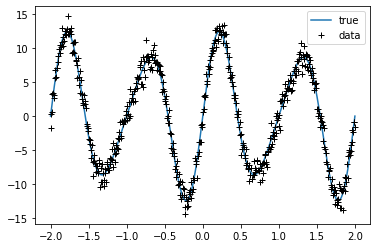

In [6]:
plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y, 'k+', label='data')
plt.legend()
plt.show()

## Split data in Train / Validaton / Test

In [7]:
n = x.shape[0]
print(n)

500


In [8]:
# shuffle index
seed = np.random.seed(12112020)
idx = np.random.permutation(np.arange(0, n))
print(idx[:20])

[169 400 279 193 330 421 274 164  97  28 120 302 198 287 396 367 476  84
 258 474]


In [10]:
# define percentages train / validation / test
p_train = 0.7
p_val   = 0.15

# define index where the data will be cut
a = int(n*p_train)
b = int(n*(p_train + p_val))

# split
x_train = x[idx[:a]]
x_val   = x[idx[a:b]]
x_test  = x[idx[b:]]

y_train = y[idx[:a]]
y_val   = y[idx[a:b]]
y_test  = y[idx[b:]]

The input and output data for a keras neural network must be in the form of numpy arrays. 

The input data (x_train, x_val, x_test) must be of shape $(n,d_1)$, where $n$ is the number of samples, $d_1$ the dimension of each sample.
Same for the output data (y_train, y_val, y_test) must be of shaope $(n,d_2)$, where $n$ is the number of samples, $d_2$ the dimension of each output sample.

If not, you can use the numpy $\texttt{reshape}$ attribute to modify the shape of the data.

In [ ]:
# print shape of data (just for verification)
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
# plot x_train and y_train data
plt.figure()
plt.plot(x_train, y_true[idx[:int(n*p_train)]], 'b.', label='true')
plt.plot(x_train, y_train, 'k+', label='data')
plt.legend()
plt.show()

In [ ]:
# define input_shape
input_shape = x_train.shape[1:]
print(input_shape)

## Define Model

In [ ]:
def fully_connected_model(input_shape):
    I = Input(input_shape, name='input')                # input layer
    X = Dense(8, activation='relu', name='dense1')(I)   # dense layer 1
    X = Dense(1, activation=None, name='output')(X)     # output layer
    
    model = Model(I, X, name='Example_1')               # return a neural model
    return model

In [ ]:
if 'model' in globals(): del model             # to reset model
model = fully_connected_model(input_shape)

In [ ]:
model.summary()

## Training process

In [ ]:
# define optimizer, loss function and metrics
alpha = 1.
opt = optimizers.Adam(learning_rate=alpha, decay=1e-3)
#opt = optimizers.SGD(learning_rate=alpha, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [ ]:
# fitting
tic = time()
history = model.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=[x_val, y_val], verbose=1)
toc = time()
print('total training time:', toc-tic, 'seconds')

In [ ]:
history_dict = history.history
keys = list(history_dict.keys())
print(keys)

In [ ]:
loss = history.history[keys[0]]
met = history.history[keys[1]]
val_loss = history.history[keys[2]]
val_met = history.history[keys[3]]

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, met, 'r', label='Training metric')
plt.plot(epochs, val_met, 'g', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel(keys[1])
plt.legend()
plt.show()

In [ ]:
# save model
save_model(model, 'Example_1.h5')

In [ ]:
test = model.evaluate(x_test, y_test)
print('test MSE:', test[0])
print('test MAE:', test[1])

If you want to load your saved model, just uncomment the following line.

In [ ]:
# load a saved model
#model = load_model('Example_1.h5')

## Predict on new data

In [ ]:
y_hat = model.predict(x_test)
print(y_hat.shape)

In [ ]:
# plot x_test, y_test and predicted data
plt.figure()
plt.plot(x_test, y_test, 'bo', label='observed data')
plt.plot(x_test, y_hat, 'ro', label='predicted data')
plt.legend()
plt.show()

In [ ]:
xidx = np.argsort(x_test.ravel())
x_test_ord = x_test[xidx]
y_test_ord = y_test[xidx]
y_hatt_ord = y_hat[xidx]

In [ ]:
plt.figure()
plt.plot(x_test_ord, y_test_ord, 'b-', label='observed data')
plt.plot(x_test_ord, y_hatt_ord, 'r-', label='predicted data')
plt.legend()
plt.show()

## Define a Second Model

In [ ]:
def fully_connected_model_2(input_shape):
    I = Input(input_shape, name='input')                 # input layer
    ### ADD SOME LAYERS HERE ###
        
    model = Model(I, X, name='Example_2')                # return model
    return model

In [ ]:
if 'model2' in globals(): del model2
model2 = None
model2 = fully_connected_model_2(input_shape)

In [ ]:
model2.summary()

## Training process

In [ ]:
# define optimizer, loss function and metrics
alpha = 1e-3
opt = optimizers.Adam(learning_rate=alpha, decay=1e-3)

model2.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [ ]:
# fitting
tic = time()
history = model2.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=[x_val, y_val], verbose=1)
toc = time()
print('total training time:', toc-tic, 'seconds')

In [ ]:
history_dict = history.history
keys = list(history_dict.keys())
print(keys)

In [ ]:
#plot learning curves
loss = history.history[keys[0]]
met = history.history[keys[1]]
val_loss = history.history[keys[2]]
val_met = history.history[keys[3]]

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, met, 'r', label='Training metric')
plt.plot(epochs, val_met, 'g', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel(keys[1])
plt.legend()
plt.show()

In [ ]:
# save model
save_model(model2, 'Example_2.h5')

In [ ]:
# evaluate performance on test data
test = model2.evaluate(x_test, y_test)
print('test MSE:', test[0])
print('test MAE:', test[1])

## Predict on new data

In [ ]:
y_hat = model2.predict(x_test)
print(y_hat.shape)

In [ ]:
# plot test and predicted data
plt.figure()
plt.plot(x_test, y_test, 'bo', label='observed data')
plt.plot(x_test, y_hat, 'ro', label='predicted data')
plt.legend()
plt.show()

In [ ]:
xidx = np.argsort(x_test.ravel())
x_test_ord = x_test[xidx]
y_test_ord = y_test[xidx]
y_hatt_ord = y_hat[xidx]

In [ ]:
plt.figure()
plt.plot(x_test_ord, y_test_ord, 'b-', label='observed data')
plt.plot(x_test_ord, y_hatt_ord, 'r-', label='predicted data')
plt.legend()
plt.show()

In [ ]:
x_new = np.linspace(2.0, 3.0, 21).reshape(-1,1)
print(x_new.T)

In [ ]:
y_new = f(x_new, sigma=0.)
print(y_new.T)

In [ ]:
y_new_hat = model2.predict(x_new)

In [ ]:
plt.figure()
plt.plot(x_test_ord, y_test_ord, 'b-', label='observed data')
plt.plot(x_test_ord, y_hatt_ord, 'r-', label='predicted data')
plt.plot(x_new, y_new, 'k-', label='observed new')
plt.plot(x_new, y_new_hat, 'g-', label='predicted new')

plt.legend()
plt.show()

## Exercise 1

Consider now synthetic data generated by function $g$.

1. Explore the new data. Split in train, validation and test.
2. Define a neural network model, with various dense layers (choose the number of neuron as your election). 
3. Train your model and evaluate your results with the test data (plot a graph comparing the y_test and the predicted estimations by the model). 

If possible, explore differente activation functions, such as 'sigmoid', 'tanh', 'leaky-relu'.

If possible, explore different optimizers (e.g. SGD, RMSProp, Adagrad, Adamax), different learning rates, a different batch size.

In [ ]:
train_size = 1000
noise = 0.15

In [ ]:
# generate new data
x = np.linspace(0., 10., train_size).reshape(-1,1)
print(x.shape)

y = g(x, sigma=noise)
y_true = g(x, sigma=0.)

In [ ]:
plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y, 'k+', label='data')
plt.legend()
plt.show()

## Split data in Train / Validaton / Test

In [ ]:
n = x.shape[0]
print(n)

In [ ]:
# shuffle index
seed = np.random.seed(12112020)
idx = np.random.permutation(np.arange(0, n))
print(idx[:20])

In [ ]:
### DEFINE YOUR PERCENTAGES FOR TRAIn / VALIDATION / TEST ###
p_train = 
p_val   = 

### DEFINE YOUR INDEX WHERE THE DATA WILL BE CUT ###
a =
b =

### SPLIT YOUR DATA IN TRINING, VALIDATION AND TEST HERE ###


In [ ]:
# print shape of data (just for verification)
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
# plot x_train and y_train data
plt.figure()
plt.plot(x_train, y_true[idx[:a]], 'b.', label='true')
plt.plot(x_train, y_train, 'k+', label='data')
plt.legend()
plt.show()

In [ ]:
# define input_shape
input_shape = x_train.shape[1:]
print(input_shape)

In [ ]:
### DEFINE YOUR MODEL HERE ###
    

In [ ]:
if 'model_ex2' in globals(): del model_ex2
model_ex2 = None

### CREATE THE NEW INSTANCE OF YOUR MODEL HERE ###
model_ex2 = 

In [ ]:
model_ex2.summary()

## Training process

In [ ]:
# define optimizer, loss function and metrics

### DEFINE ALPHA AND OPTIMIZER HERE ###

### COMPILE YOUR MODEL HERE ###

In [ ]:
# fitting
tic = time()
### FIT YOUR MODEL HERE ###

toc = time()
print('total training time:', toc-tic, 'seconds')

In [ ]:
history_dict = history.history
keys = list(history_dict.keys())
print(keys)

In [ ]:
# plot learning curves
loss = history.history[keys[0]]
met = history.history[keys[1]]
val_loss = history.history[keys[2]]
val_met = history.history[keys[3]]

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, met, 'r', label='Training metric')
plt.plot(epochs, val_met, 'g', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel(keys[1])
plt.legend()
plt.show()

In [ ]:
# save model
save_model(model_ex2, 'Exercise_2.h5')

In [ ]:
# evaluate performance on test data
test = model_ex2.evaluate(x_test, y_test)
print('test MSE:', test[0])
print('test MAE:', test[1])

## Predict on new data

In [ ]:
y_hat = model_ex2.predict(x_test)
print(y_hat.shape)

In [ ]:
# plot test and predicted data
plt.figure()
plt.plot(x_test, y_test, 'bo', label='observed data')
plt.plot(x_test, y_hat, 'ro', label='predicted data')
plt.legend()
plt.show()

## Exercise 2

Train a fully connected neural network to estimate the number of infected people by Covid-19.
Use the data provided for the Project 1 by professor Leticia.

1. Explore the new data. Split in train, validation and test.
2. Define a neural network model, with various dense layers (choose the number of neuron as your election). 
3. Train your model and evaluate your results with the test data (plot a graph comparing the y_test and the predicted estimations by the model).
4. Try to make predictions in the following days after the last available data (not too far).

Observation: I recommend not to aggregate the data by week, because this will severely reduce the number of samples. Use data by day. If you want to reduce the noise in the data, instead of the raw numbers you can replace them by an moving average of 7 days.